## Installation and setup
<a id='Install'></a>

As of 8/28/16, the latest stable release of TF is r0.10, which does not contain the latest version of slim.
To obtain the latest version of TF-Slim, please install the most recent nightly build of TF
as explained [here](https://github.com/tensorflow/models/tree/master/slim#installing-latest-version-of-tf-slim).

To use TF-Slim for image classification (as we do in this notebook), you also have to install the TF-Slim image models library from [here](https://github.com/tensorflow/models/tree/master/slim). Let's suppose you install this into a directory called TF_MODELS. Then you should change directory to  TF_MODELS/slim **before** running this notebook, so that these files are in your python path.

To check you've got these two steps to work, just execute the cell below. If it complains about unknown modules, restart the notebook after moving to the TF-Slim models directory.


In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
slim = tf.contrib.slim

### Display some of the data.

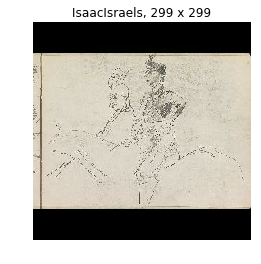

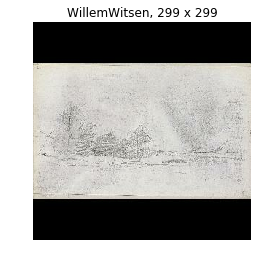

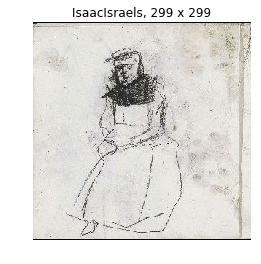

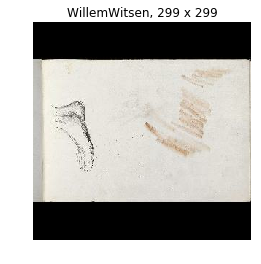

In [2]:
from datasets import geweldig
import tensorflow as tf

slim = tf.contrib.slim

geweldig_data_dir = '/home/tarabalakrishnan/geweldig/data/images_top10'

with tf.Graph().as_default(): 
    dataset = geweldig.get_split('train', geweldig_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in xrange(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

# Convolutional neural nets (CNNs).
<a id='CNN'></a>

In this section, we show how to train an image classifier using a simple CNN.


### Define the model.

Below we define a simple CNN. Note that the output layer is linear function - we will apply softmax transformation externally to the model, either in the loss function (for training), or in the prediction function (during testing).

In [3]:
def my_cnn(images, num_classes, is_training):  # is_training is not used...
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(images, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, num_classes, activation_fn=None)       
        return net

### Apply the model to some randomly generated images.

In [14]:
import tensorflow as tf

with tf.Graph().as_default():
    # The model can handle any input size because the first layer is convolutional.
    # The size of the model is determined when image_node is first passed into the my_cnn function.
    # Once the variables are initialized, the size of all the weight matrices is fixed.
    # Because of the fully connected layers, this means that all subsequent images must have the same
    # input size as the first image.
    batch_size, height, width, channels = 3, 28, 28, 3
    images = tf.random_uniform([batch_size, height, width, channels], maxval=1)
    
    # Create the model.
    num_classes = 10
    logits = my_cnn(images, num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
  
    # Initialize all the variables (including parameters) randomly.
    init_op = tf.global_variables_initializer()
  
    with tf.Session() as sess:
        # Run the init_op, evaluate the model outputs and print the results:
        sess.run(init_op)
        probabilities = sess.run(probabilities)
        
print('Probabilities Shape:')
print(probabilities.shape)  # batch_size x num_classes 

print('\nProbabilities:')
print(probabilities)

print('\nSumming across all classes (Should equal 1):')
print(np.sum(probabilities, 1)) # Each row sums to 1

Probabilities Shape:
(3, 10)

Probabilities:
[[ 0.07797118  0.11779195  0.06907468  0.13265043  0.11672731  0.09492826
   0.11400408  0.13051286  0.06326394  0.08307524]
 [ 0.07314871  0.11621763  0.07299127  0.1170013   0.11585766  0.09682563
   0.12191526  0.13349637  0.06403948  0.08850663]
 [ 0.07540853  0.11038633  0.0723519   0.12407389  0.11849985  0.09712954
   0.12768133  0.12556656  0.0657687   0.08313347]]

Summing across all classes (Should equal 1):
[ 0.99999994  0.99999994  1.00000012]


### Train the model on the Geweldig dataset.

Make sure you've downloaded the geweldig dataset. 

ignore below:
Before starting, make sure you've run the code to <a href="#DownloadFlowers">Download the Flowers</a> dataset. Now, we'll get a sense of what it looks like to use TF-Slim's training functions found in
[learning.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/learning.py). First, we'll create a function, `load_batch`, that loads batches of dataset from a dataset. Next, we'll train a model for a single step (just to demonstrate the API), and evaluate the results.

In [8]:
from preprocessing import inception_preprocessing
import tensorflow as tf

slim = tf.contrib.slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [19]:
from datasets import geweldig

# This might take a few minutes.
train_dir = '../../../data/tfslim_model/'
print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = geweldig.get_split('train', geweldig_data_dir)
    images, _, labels = load_batch(dataset)
  
    # Create the model:
    logits = my_cnn(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    tf.losses.softmax_cross_entropy(one_hot_labels, logits)
    #slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    #total_loss = slim.losses.get_total_loss()
    total_loss = tf.losses.get_total_loss()
    print("TOTAL LOSS: ", total_loss)

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=5, # For speed, we just do 1 epoch
      save_summaries_secs=1)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to ../../../data/tfslim_model/
('TOTAL LOSS: ', <tf.Tensor 'total_loss:0' shape=() dtype=float32>)
INFO:tensorflow:Restoring parameters from ../../../data/tfslim_model/model.ckpt-17


INFO:tensorflow:Restoring parameters from ../../../data/tfslim_model/model.ckpt-17


INFO:tensorflow:Starting Session.


INFO:tensorflow:Starting Session.


INFO:tensorflow:Starting Queues.


INFO:tensorflow:Starting Queues.


INFO:tensorflow:global step 18: loss = 2.3389 (33.68 sec/step)


INFO:tensorflow:global step 18: loss = 2.3389 (33.68 sec/step)


INFO:tensorflow:Stopping Training.


INFO:tensorflow:Stopping Training.


INFO:tensorflow:Finished training! Saving model to disk.


INFO:tensorflow:Finished training! Saving model to disk.


Finished training. Final batch loss 2


### Evaluate some metrics.

As we discussed above, we can compute various metrics besides the loss.
Below we show how to compute prediction accuracy of the trained model, as well as top-10 classification accuracy. (The difference between evaluation and evaluation_loop is that the latter writes the results to a log directory, so they can be viewed in tensorboard.)

In [18]:
from datasets import geweldig

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = geweldig.get_split('train', geweldig_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = my_cnn(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels), #how often predictions match labels
        'eval/Recall@10': slim.metrics.streaming_recall_at_k(logits, labels, 10),  #true pos/false neg 
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=names_to_updates.values(),
        final_op=names_to_values.values())

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].


Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].


Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-05-16-02:16:29


INFO:tensorflow:Starting evaluation at 2017-05-16-02:16:29


INFO:tensorflow:Restoring parameters from ../../../data/tfslim_model/model.ckpt-17


INFO:tensorflow:Restoring parameters from ../../../data/tfslim_model/model.ckpt-17


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Finished evaluation at 2017-05-16-02:16:31


INFO:tensorflow:Finished evaluation at 2017-05-16-02:16:31


eval/Accuracy: 0.062500
eval/Recall@10: 1.000000


# Using pre-trained models
<a id='Pretrained'></a>

Neural nets work best when they have many parameters, making them very flexible function approximators.
However, this  means they must be trained on big datasets. Since this process is slow, we provide various pre-trained models - see the list [here](https://github.com/tensorflow/models/tree/master/slim#pre-trained-models).


You can either use these models as-is, or you can perform "surgery" on them, to modify them for some other task. For example, it is common to "chop off" the final pre-softmax layer, and replace it with a new set of weights corresponding to some new set of labels. You can then quickly fine tune the new model on a small new dataset. We illustrate this below, using inception-v1 as the base model. While models like Inception V3 are more powerful, Inception V1 is used for speed purposes.

Take into account that VGG and ResNet final layers have only 1000 outputs rather than 1001. The ImageNet dataset provied has an empty background class which can be used to fine-tune the model to other tasks. VGG and ResNet models provided here don't use that class. We provide two examples of using pretrained models: Inception V1 and VGG-19 models to highlight this difference.


### Download the Inception V1 checkpoint




In [21]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.



### Apply Pre-trained Inception V1 model to Images.

We have to convert each image to the size expected by the model checkpoint.
There is no easy way to determine this size from the checkpoint itself.
So we use a preprocessor to enforce this.

INFO:tensorflow:Restoring parameters from /tmp/checkpoints/inception_v1.ckpt


INFO:tensorflow:Restoring parameters from /tmp/checkpoints/inception_v1.ckpt


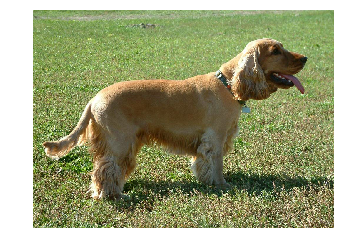

Probability 45.14% => [cocker spaniel, English cocker spaniel, cocker]
Probability 21.55% => [Sussex spaniel]
Probability 10.37% => [Irish setter, red setter]
Probability 5.06% => [Welsh springer spaniel]
Probability 2.99% => [clumber, clumber spaniel]
Probability 1.79% => [English setter]
Probability 1.09% => [English springer, English springer spaniel]
Probability 0.56% => [golden retriever]
Probability 0.46% => [Gordon setter]
Probability 0.43% => [vizsla, Hungarian pointer]


In [22]:
import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing

slim = tf.contrib.slim

image_size = inception.inception_v1.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib2.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(10):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

### Download the VGG-16 checkpoint

In [ ]:
from datasets import dataset_utils
import tensorflow as tf

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)


### Apply Pre-trained VGG-16 model to Images.

We have to convert each image to the size expected by the model checkpoint.
There is no easy way to determine this size from the checkpoint itself.
So we use a preprocessor to enforce this. Pay attention to the difference caused by 1000 classes instead of 1001.

In [ ]:
import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

slim = tf.contrib.slim

image_size = vgg.vgg_16.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/d/d9/First_Student_IC_school_bus_202076.jpg'
    image_string = urllib2.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = vgg_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        # 1000 classes instead of 1001.
        logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()
    
    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Shift the index of a class name by one. 
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index+1]))

### Fine-tune the model on a different set of labels.

We will fine tune the inception model on the Geweldig dataset.

In [46]:
# Note that this may take several minutes.

import os

from datasets import geweldig
from nets import inception
from preprocessing import inception_preprocessing

slim = tf.contrib.slim
image_size = inception.inception_v1.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)


train_dir = '/tmp/inception_finetuned/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = geweldig.get_split('train', geweldig_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=2)
        
  
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.


Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.


Instructions for updating:
Use tf.losses.compute_weighted_loss instead.


Instructions for updating:
Use tf.losses.compute_weighted_loss instead.


Instructions for updating:
Use tf.losses.add_loss instead.


Instructions for updating:
Use tf.losses.add_loss instead.


Instructions for updating:
Use tf.losses.get_total_loss instead.


Instructions for updating:
Use tf.losses.get_total_loss instead.


Instructions for updating:
Use tf.losses.get_losses instead.


Instructions for updating:
Use tf.losses.get_losses instead.


Instructions for updating:
Use tf.losses.get_regularization_losses instead.


Instructions for updating:
Use tf.losses.get_regularization_losses instead.


INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.


INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.


INFO:tensorflow:Restoring parameters from /tmp/checkpoints/inception_v1.ckpt


INFO:tensorflow:Restoring parameters from /tmp/checkpoints/inception_v1.ckpt


INFO:tensorflow:Starting Session.


INFO:tensorflow:Starting Session.


INFO:tensorflow:Starting Queues.


INFO:tensorflow:Starting Queues.


INFO:tensorflow:global step 1: loss = 2.8161 (17.80 sec/step)


INFO:tensorflow:global step 1: loss = 2.8161 (17.80 sec/step)


INFO:tensorflow:global step 2: loss = 2.3039 (10.53 sec/step)


INFO:tensorflow:global step 2: loss = 2.3039 (10.53 sec/step)


INFO:tensorflow:Stopping Training.


INFO:tensorflow:Stopping Training.


INFO:tensorflow:Finished training! Saving model to disk.


INFO:tensorflow:Finished training! Saving model to disk.


Finished training. Last batch loss 2.303902


### Apply fine tuned model to some images.

In [63]:
import numpy as np
import tensorflow as tf
from datasets import geweldig
from nets import inception

slim = tf.contrib.slim

image_size = inception.inception_v1.default_image_size
batch_size = 600

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = geweldig.get_split('train', geweldig_data_dir)
    print("data shape: ", dataset.num_samples)
    images, images_raw, labels = load_batch(dataset, batch_size=600, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    print("prob shape: ", probabilities.shape)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())

    correct = 0.0
    total = 0.0
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in xrange(batch_size):
                if i == 0:
                    print(np_images_raw.shape)
                    print(np_labels.shape)
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]

                total += 1
                if predicted_name == true_name:
                    correct += 1
                    
                if i % 10 == 0:
                    print("Step: ", i, " Accuracy: ", correct / (total * 1.0))
                
    print("Total Accuracy: ", correct / (total * 1.0))
                
    '''
    plt.figure()
    plt.imshow(image.astype(np.uint8))
    plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
    plt.axis('off')
    plt.show()
    '''

data shape:  600
prob shape:  (600, 10)
Instructions for updating:
Use `tf.local_variables_initializer` instead.


Instructions for updating:
Use `tf.local_variables_initializer` instead.


INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-2


INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-2


(600, 224, 224, 3)
(600,)
Step:  0  Accuracy:  1.0
Step:  10  Accuracy:  0.727272727273
Step:  20  Accuracy:  0.52380952381
Step:  30  Accuracy:  0.612903225806
Step:  40  Accuracy:  0.634146341463
Step:  50  Accuracy:  0.647058823529
Step:  60  Accuracy:  0.672131147541
Step:  70  Accuracy:  0.69014084507
Step:  80  Accuracy:  0.716049382716
Step:  90  Accuracy:  0.681318681319
Step:  100  Accuracy:  0.643564356436
Step:  110  Accuracy:  0.612612612613
Step:  120  Accuracy:  0.611570247934
Step:  130  Accuracy:  0.625954198473
Step:  140  Accuracy:  0.602836879433
Step:  150  Accuracy:  0.596026490066
Step:  160  Accuracy:  0.590062111801
Step:  170  Accuracy:  0.59649122807
Step:  180  Accuracy:  0.563535911602
Step:  190  Accuracy:  0.544502617801
Step:  200  Accuracy:  0.547263681592
Step:  210  Accuracy:  0.530805687204
Step:  220  Accuracy:  0.52036199095
Step:  230  Accuracy:  0.519480519481
Step:  240  Accuracy:  0.510373443983
Step:  250  Accuracy:  0.490039840637
Step:  260  

# MNIST Tutorial


In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np

In [44]:
dataset_train = geweldig.get_split('train', geweldig_data_dir)
images_train, images_raw_train, labels_train = load_batch(dataset_train, height=image_size, width=image_size)

dataset_val = geweldig.get_split('validation', geweldig_data_dir)
images_val, images_raw_val, labels_val = load_batch(dataset_val, height=image_size, width=image_size)
